In [109]:
#%%cython

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.fftpack import fftshift, ifftshift, fft2, ifft2
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from scipy.signal import correlate2d as correlate
from scipy.signal import general_gaussian
import pyfits
from scipy import ndimage


In [110]:

# Zernike polynomials in polar coordinates
def Zernike_polar(coefficients, r, u):
 Z = coefficients
 Z1  =  Z[0]  * 1*(np.cos(u)**2+np.sin(u)**2)
 Z2  =  Z[1]  * 2*r*np.cos(u)
 Z3  =  Z[2]  * 2*r*np.sin(u)
 Z4  =  Z[3]  * np.sqrt(3)*(2*r**2-1)
 Z5  =  Z[4]  * np.sqrt(6)*r**2*np.sin(2*u)
 Z6  =  Z[5]  * np.sqrt(6)*r**2*np.cos(2*u)
 Z7  =  Z[6]  * np.sqrt(8)*(3*r**2-2)*r*np.sin(u)
 Z8  =  Z[7]  * np.sqrt(8)*(3*r**2-2)*r*np.cos(u)
 '''
 Z9  =  Z[8]  * np.sqrt(8)*r**3*np.sin(3*u)
 Z10 =  Z[9] * np.sqrt(8)*r**3*np.cos(3*u)
 
 Z11 =  Z[10] * np.sqrt(5)*(1-6*r**2+6*r**4)
 Z12 =  Z[11] * np.sqrt(10)*(4*r**2-3)*r**2*np.cos(2*u)
 Z13 =  Z[12] * np.sqrt(10)*(4*r**2-3)*r**2*np.sin(2*u)
 Z14 =  Z[13] * np.sqrt(10)*r**4*np.cos(4*u)
 Z15 =  Z[14] * np.sqrt(10)*r**4*np.sin(4*u)
 Z16 =  Z[15] * np.sqrt(12)*(10*r**4-12*r**2+3)*r*np.cos(u)
 
 Z17 =  Z[16] * np.sqrt(12)*(10*r**4-12*r**2+3)*r*np.sin(u)
 Z18 =  Z[17] * np.sqrt(12)*(5*r**2-4)*r**3*np.cos(3*u)
 Z19 =  Z[18] * np.sqrt(12)*(5*r**2-4)*r**3*np.sin(3*u)
 Z20 =  Z[19] * np.sqrt(12)*r**5*np.cos(5*u)
 Z21 =  Z[20] * np.sqrt(12)*r**5*np.sin(5*u)
 Z22 =  Z[21] * np.sqrt(7)*(20*r**6-30*r**4+12*r**2-1)
 Z23 =  Z[22] * np.sqrt(14)*(15*r**4-20*r**2+6)*r**2*np.sin(2*u)
 Z24 =  Z[23] * np.sqrt(14)*(15*r**4-20*r**2+6)*r**2*np.cos(2*u)
 Z25 =  Z[24] * np.sqrt(14)*(6*r**2-5)*r**4*np.sin(4*u)
 Z26 =  Z[25] * np.sqrt(14)*(6*r**2-5)*r**4*np.cos(4*u)
 Z27 =  Z[26] * np.sqrt(14)*r**6*np.sin(6*u)
 Z28 =  Z[27] * np.sqrt(14)*r**6*np.cos(6*u)
 Z29 =  Z[28] * 4*(35*r**6-60*r**4+30*r**2-4)*r*np.sin(u)
 Z30 =  Z[29] * 4*(35*r**6-60*r**4+30*r**2-4)*r*np.cos(u)
 Z31 =  Z[30] * 4*(21*r**4-30*r**2+10)*r**3*np.sin(3*u)
 Z32 =  Z[31] * 4*(21*r**4-30*r**2+10)*r**3*np.cos(3*u)
 Z33 =  Z[32] * 4*(7*r**2-6)*r**5*np.sin(5*u)
 Z34 =  Z[33] * 4*(7*r**2-6)*r**5*np.cos(5*u)
 Z35 =  Z[34] * 4*r**7*np.sin(7*u)
 Z36 =  Z[35] * 4*r**7*np.cos(7*u)
 Z37 =  Z[36] * 3*(70*r**8-140*r**6+90*r**4-20*r**2+1)
 '''
 ZW =  Z1+Z2+Z3+Z4+  Z5+  Z6+  Z7+  Z8 #+  Z9+ Z10+ Z11+ Z12+ Z13+ Z14+ Z15+ Z16+ Z17+ Z18+ Z19+Z20+ Z21+ Z22+ Z23+ Z24+ Z25+ Z26+ Z27+ Z28+ Z29+Z30+ Z31+ Z32+ Z33+ Z34+ Z35+ Z36+ Z37
 return ZW

In [111]:
def pupil_size(D,lam,pix,size):
    pixrad = pix*np.pi/(180*3600)  # Pixel-size in radians
    nu_cutoff = D/lam      # Cutoff frequency in rad^-1
    deltanu = 1./(size*pixrad)     # Sampling interval in rad^-1
    rpupil = nu_cutoff/(2*deltanu) #pupil size in pixels
    return np.int(rpupil)


# In[144]:


## function for making the phase in a unit circle
def phase(coefficients,rpupil):
 r = 1
 x = np.linspace(-r, r, 2*rpupil)
 y = np.linspace(-r, r, 2*rpupil)

 [X,Y] = np.meshgrid(x,y) 
 R = np.sqrt(X**2+Y**2)
 theta = np.arctan2(Y, X)
    
 Z = Zernike_polar(coefficients,R,theta)
 Z[R>1] = 0
 return Z


# In[145]:


## function for making the aberrated phase
def phase_aberr(del_z,rpupil):
 alpha_4 = (del_z*np.pi)/np.sqrt(3)
 r = 1
 x = np.linspace(-r, r, 2*rpupil)
 y = np.linspace(-r, r, 2*rpupil)
 [X,Y] = np.meshgrid(x,y)
 theta = np.arctan2(Y, X)


 #ph_defocus = -(np.pi*del_z*(X**2+Y**2)*D**2)/(4*lam*f**2)
 R = np.sqrt(X**2 + Y**2)
 ph_defocus = alpha_4  * np.sqrt(3)*(2*R**2-1)
 ph_defocus[R>1] = 0
 return ph_defocus


# In[146]:


## function for making the complex pupil function from Zernike
def pupil_foc(coefficients,size,rpupil):
    #rpupil = pupil_size(D,lam,pix,size)
    A = np.zeros([size,size])
    A[size//2-rpupil+1:size//2+rpupil+1,size//2-rpupil+1:size//2+rpupil+1]= phase(coefficients,rpupil)
    aberr =  np.exp(1j*A)
    return aberr


# In[147]:


## function for making the complex pupil function for the defocused wavefront
def pupil_defocus(coefficients,size,del_z,rpupil):
    #rpupil = pupil_size(D,lam,pix,size)
    A = np.zeros([size,size])
    A[size//2-rpupil+1:size//2+rpupil+1,size//2-rpupil+1:size//2+rpupil+1] = phase_aberr(del_z,rpupil)+phase(coefficients,rpupil)
    
    aberr_defocus =  np.exp(1j*A)
    return  aberr_defocus


# In[11]:


'''
def mask(pupil_size,size):
    maskCenter = np.floor(size/ 2)
    W, H       = np.meshgrid(np.arange(0, size), np.arange(0, size))
    mask       = np.sqrt((W - maskCenter)**2 + (H- maskCenter)**2) < pupil_size
    return mask
'''



# In[148]:

'''
def mask(pupil_size,N):
 C = np.zeros((N, N))
 coords= np.arange(0, N, 1.0)
 x, y = np.meshgrid(coords, coords)
 x -= N / 2.
 y -= N / 2.
 m = x * x + y * y <= pupil_size**2
 C[m] = 1
 return C
'''
def mask(rpupil, size):
 r = 1
 x = np.linspace(-r, r, 2*rpupil)
 y = np.linspace(-r, r, 2*rpupil) 

 [X,Y] = np.meshgrid(x,y) 
 R = np.sqrt(X**2+Y**2)
 theta = np.arctan2(Y, X)
 M = 1*(np.cos(theta)**2+np.sin(theta)**2)
 M[R>1] = 0
 Mask =  np.zeros([size,size])
 Mask[size//2-rpupil+1:size//2+rpupil+1,size//2-rpupil+1:size//2+rpupil+1]= M
 return Mask



def complex_pupil(mask,abbe):
    a = mask*abbe
    return a
## function to compute the amplitude of PSF from the complex pupil function

def PSF(mask,abbe):
    ## making zero where the aberration is equal to 1 (the zero background)
 abbe_z = np.zeros((len(abbe),len(abbe)),dtype=np.complex)
 abbe_z = mask*abbe
 PSF = ifftshift(fft2(fftshift(abbe_z)))
 PSF = (np.abs(PSF))**2 #or PSF*PSF.conjugate()
 #PSF = PSF/PSF.sum()
 return PSF


# In[648]:


#
## function to compute the OTF from PSF (to be used in PD fit )
def OTF(psf):
    otf = fftshift(psf)
    otf = fft2(otf)
    otf = otf/float(otf[0,0])
    #sotf = otf/otf.max() # or otf_max = otf[size/2,size/2] if max is shifted to center
   
    return otf


# In[649]:


#
## function to return MTF from OTF:
def MTF(otf):
    mtf = np.abs(otf)
    return mtf






#
## function to compute the FT of focused and defocused image
def FT(im0, imk):
    d0 = fft2(im0)
    dk = fft2(imk)
    return d0, dk
    


# In[647]:


#
## function to define the Q matrix (Eq. 6 of L\"odfahl & scharmer. 1994)
def Q_matrix(t0,tk,reg,gamma):
    tmp = np.abs(t0)**2 + gamma*np.abs(tk)**2 +reg
    q = 1./(np.sqrt(tmp))
    q2 = q*q
    return q, q2


# In[646]:


#
## function to compute the optimized object (Eq. 5 of L\"odfahl & scharmer.1994)
def F_M(q2,d0,dk,t0,tk,filter,gamma):
    F_M = filter*q2*(d0*np.conj(t0) + gamma*dk*np.conj(tk))
    return F_M







#
## function to define the error metric to be minimized (Eq. 9 of  L\"odfahl & scharmer.1994)

def Error_metric(t0,tk,d0,dk,q,filter):
    ef = filter*(dk*t0 - d0*tk)
    ef = q*ef
    EF = fft2((ef))
    EF = EF.real
    #EF = EF[low:high,low:high] 
    EF = EF-EF.mean()
    return  EF


'''
def Error_metric(t0,tk,d0,dk,q,filter,gamma,f_m):
  
   ef = (ifft2(d0).real - ifft2(f_m*t0).real) + gamma*(ifft2(dk).real - ifft2(dk - f_m*tk).real)
   EF = fft2((ef))
   EF = EF.real
    #EF = EF[low:high,low:high] 
   EF = EF-EF.mean()
    
    #np.abs(d0 - f_m*t0)**2 + gamma*np.abs(dk - f_m*tk)**2
   return EF
'''      


def L_M(EF,size):
    #L_m = np.sum(EF*EF)/(size**2)
    L_m = np.sum(EF**2)/(size**2)
    return L_m


# In[643]:


#
# mask frequencies below a frequency threshold (to make the noise image)
def noise_mask(size,cut_off):
   X = np.linspace(-0.5,0.5,size)
   x,y = np.meshgrid(X,X)
   mask = np.ones((size,size))
   m = x * x + y * y <= cut_off**2
   mask[m] = 0
   return mask


# In[656]:


#
# to mask frequencies above a frequency threshold
def noise_mask_high(size,cut_off):
   X = np.linspace(-0.5,0.5,size)
   x,y = np.meshgrid(X,X)
   mask = np.zeros((size,size))
   m = x * x + y * y <= cut_off**2
   mask[m] = 1
   return mask


# In[494]:


def Noise_d0(im0, freq_mask):
    pd = fft2(im0)
    pd = np.abs(pd)**2
    pd = fftshift(pd)
    pd_m = pd*freq_mask
    pd_m = ifftshift(pd_m)
    return pd_m


# In[487]:


## Noise filter (Loedfahl and Berger 1998)
def sch_filter(noise_im,t0,tk,d0,dk):
    
    ab_noise = np.abs(noise_im)**2
    filter = ab_noise*(np.abs(t0)**2 + np.abs(tk)**2)/(np.abs(d0*np.conj(t0) + dk*np.conj(tk))**2 + 0.1)
    filter = 1- filter
    filter_2 = filter
    filter_2[filter<0.2] = 0
    filter_2[filter>1] = 1
    return filter_2


def Gamma(d0,dk,mask):
    d0 = np.abs(d0)**2
    dk = np.abs(dk)**2
    d0 = fftshift(d0)
    dk = fftshift(dk)
    denom = np.sum(mask)
    sigma_0 = np.sum(mask*d0)/denom
    sigma_k = np.sum(mask*dk)/denom
    gamma = sigma_0/sigma_k
    return gamma
# # Testing functions

def apo2d(masi,perc):
 s = masi.shape
 edge = 100./perc
 mean = np.mean(masi)
 masi = masi-mean
 xmask = np.ones(s[1])
 ymask = np.ones(s[0])
 smooth_x = np.int(s[1]/edge)
 smooth_y = np.int(s[0]/edge)

 for i in range(0,smooth_x):
    xmask[i] = (1.-np.cos(np.pi*np.float(i)/np.float(smooth_x)))/2.
    ymask[i] = (1.-np.cos(np.pi*np.float(i)/np.float(smooth_y)))/2.
    
 xmask[s[1] - smooth_x:s[1]] = (xmask[0:smooth_x])[::-1]
 ymask[s[0] - smooth_y:s[0]] = (ymask[0:smooth_y])[::-1]

 for i in range(0,s[1]):
    masi[:,i] = masi[:,i]*xmask[i]
 for i in range(0,s[0]):
    masi[i,:] = masi[i,:]*ymask[i]
 masi = masi+mean
 return masi


def RMS_error(im1,im2):
    return np.sqrt(1./(im1.shape[0])**2 * np.sum(im1-im2)**2)

In [112]:
def RMS_WF(array):
    rms = np.sqrt(np.sum((1/(2*np.pi)*array)**2))
    rms = 1./(rms)
    return rms

def correlation(im,im2):
    
 from scipy.stats import pearsonr
 corr, _ = pearsonr(np.ravel(im), np.ravel(im2))
 return corr*100

def RMS_con(im):
    return im.std()/im.mean()

In [113]:
def GetPSD1D(psd2D):
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(np.int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    psd1D = ndimage.mean(psd2D, r, index=np.arange(0, wc))

    return psd1D

In [114]:
def noise(im):
    from skimage.restoration import estimate_sigma
    s = estimate_sigma(im)
    return s

# Testing functions

In [115]:
import os
directory = os.getcwd()

In [116]:
masi = pyfits.getdata(directory+'/Targets/Masi_hrt.fits')
masi = masi[0:300,300:600]#[300:600,0:300]#[0:300,300:600]

In [117]:
RMS_con(masi)

0.15011382

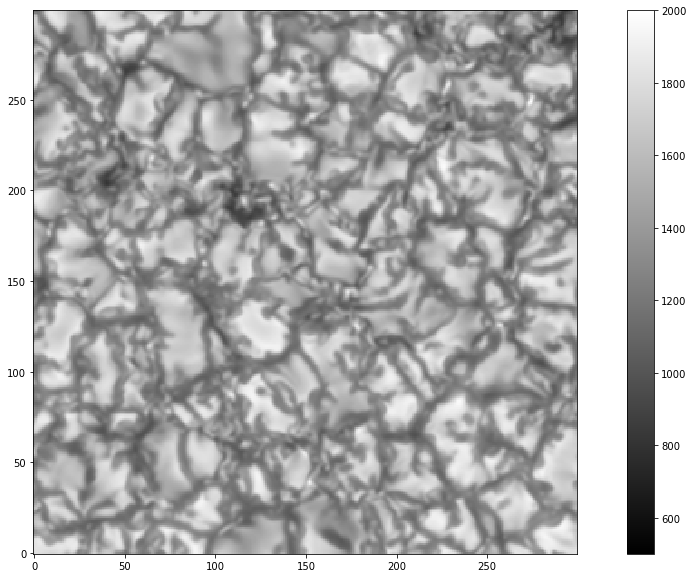

In [118]:
plt.figure(figsize=(18,10))
plt.imshow(masi,origin='lower',cmap='gray',vmin=500,vmax=2000)
plt.colorbar()

In [12]:
masi.shape

(300, 300)

In [14]:
RMS_con(masi)

0.15011382

In [16]:
noise(masi)/masi.mean()

0.003919698529199628

# Apodize

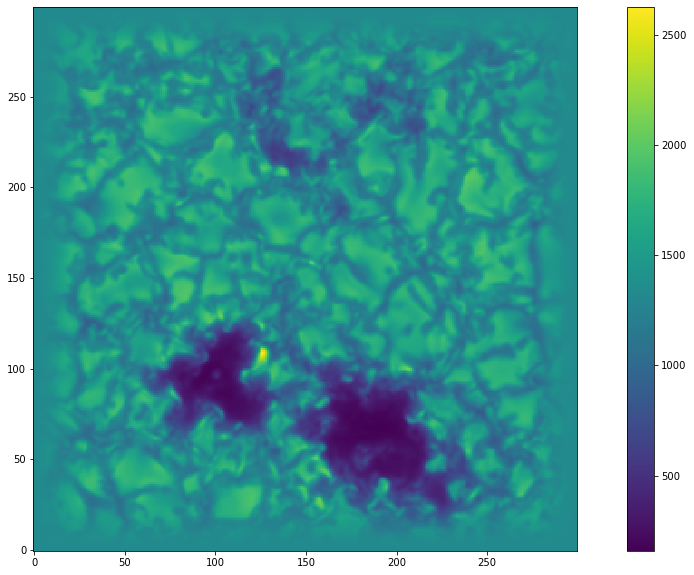

In [329]:
masi= apo2d(masi,10)
plt.figure(figsize=(18,10))
plt.imshow(masi,origin='lower')
plt.colorbar()

In [119]:
## optical system parameters (units are in mm)
pixsize = 0.01
D = 140
lam = 617.3*10**(-6)
pix = 0.5
f = 4125.3                  
size = masi.shape[0]
del_z = 0.5 # OPD
rpupil = pupil_size(D,lam,pix,size)
coefficients = np.zeros(37)

plate_scale = 0.5


In [120]:
## creating a PSF
'''
coefficients[0] = 1e-04
coefficients[1] = 1e-04
coefficients[2] = 1e-04
coefficients[3] = 0.3
coefficients[4] = 0.2
coefficients[5] = 0.1
coefficients[6] = 0.3
coefficients[7] = 0.4

coefficients[5] = 0.8
coefficients[6] = 0.33

coefficients[7] = 0.9
coefficients[8] = 0.1
coefficients[13] = 0.33
coefficients[14] = 0.7
'''
coefficients[0:8] = np.array([1e-04, 1e-04, 1e-04, 0.1,0.2,0.4,0.4,0.3])


# pupil radius
rpupil = pupil_size(D,lam,pix,size)


# simulated phase
phase_sim = phase(coefficients,rpupil)

# complex pupil function
pupil_func = pupil_foc(coefficients,size,rpupil)


# additional aberration
phase_sim_aberr = phase_aberr(del_z,rpupil)

# complex pupil function for defoc PSF
pupil_func_aberr = pupil_defocus(coefficients,size,del_z,rpupil)

# Pupil mask
Mask = mask(rpupil,size) 

# PSF
psf_foc = PSF(Mask, pupil_func)
psf_defoc = PSF(Mask,pupil_func_aberr)

# OTF
otf_foc = OTF(psf_foc)
otf_defoc = OTF(psf_defoc)





/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:137: ComplexWarning: Casting complex values to real discards the imaginary part


In [59]:
coefficients

array([1.e-04, 1.e-04, 1.e-04, 1.e-01, 2.e-01, 4.e-01, 4.e-01, 3.e-01,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00])

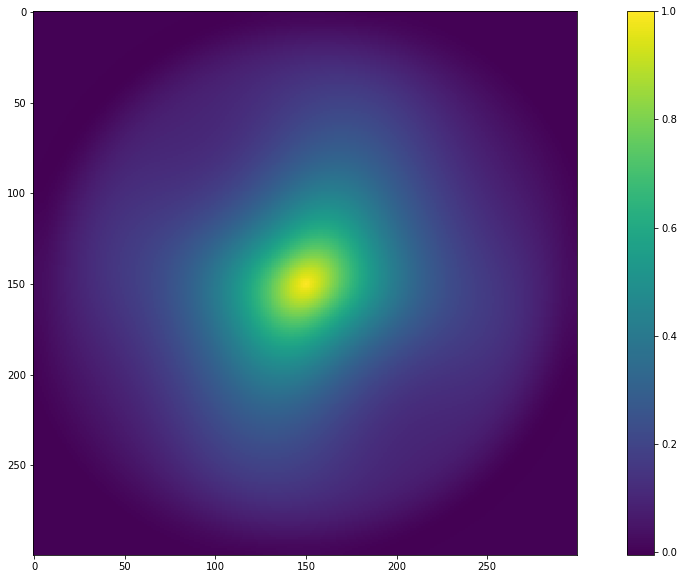

In [19]:
plt.figure(figsize=(18,10))
a = complex_pupil(Mask,pupil_func)
plt.imshow(fftshift(otf_foc).real)
plt.colorbar()

In [20]:
RMS_WF(coefficients)

9.26405102365405

In [21]:
# blurring simulation 

fft_image = np.fft.fft2(masi)
temp = fft_image*otf_foc
temp2 = fft_image*otf_defoc 
cont_foc = np.fft.ifft2(temp).real
cont_defoc = np.fft.ifft2(temp2).real

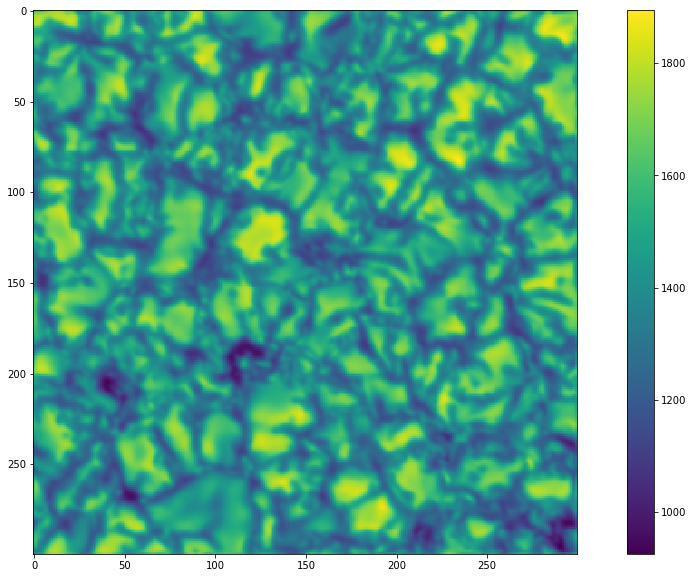

In [22]:
plt.figure(figsize=(18,10))
plt.imshow(cont_foc)
plt.colorbar()

# Add noise

In [273]:
mean=0
SNR = 300
sigma = masi.std()/np.sqrt(SNR)
gaussian =np.random.normal(mean,scale=sigma,size =(size,size))



In [274]:
sigma/masi.mean()

0.008666825121749879

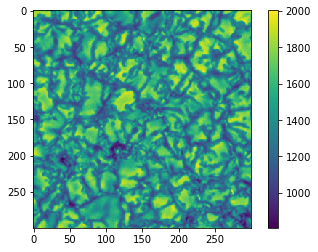

In [123]:
plt.imshow(gaussian+masi)
plt.colorbar()

In [245]:
fft_image = np.fft.fft2(masi)
temp = fft_image*otf_foc + fft2(gaussian)
temp2 = fft_image*otf_defoc + fft2(gaussian)
cont_foc = np.fft.ifft2(temp).real
cont_defoc = np.fft.ifft2(temp2).real


In [246]:
t = masi+gaussian
noise(t)

22.52998088541799

In [247]:
masi = masi.astype(float)
Pn = np.abs((fft2(gaussian)))**2
Ps = np.abs((fft2((masi))))**2
S = Pn/Ps

In [248]:
red = fft2(cont_foc)*np.conj(otf_foc)/(np.abs(otf_foc)**2+0.5)
red = ifft2(red).real

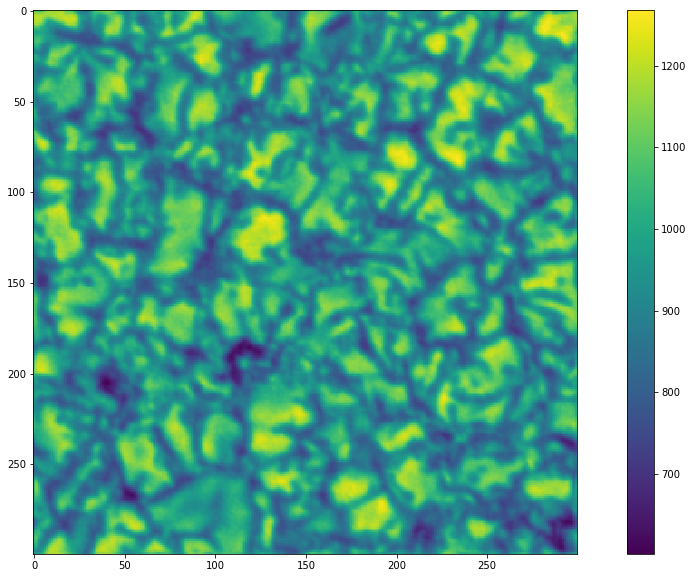

In [249]:
plt.figure(figsize=(18,10))
plt.imshow(red)
plt.colorbar()

In [250]:
noise(red)

2.44049987228652

In [251]:
noise(masi)

5.636773858541261

# Testing the code robustness

In [252]:
D = 140
lam = 617.3*10**(-6)
pix = 0.5
f = 4125.3                  
size = masi.shape[0]
del_z = 0.5

cut_off = 0.5
reg = S



In [253]:
from scipy.optimize import minimize, minimize_scalar


rpupil = pupil_size(D,lam,pix,size)

Mask = mask(rpupil,size) 

cont_foc = apo2d(cont_foc,10)
cont_defoc = apo2d(cont_defoc,10)


d0 = FT(cont_foc,cont_defoc)[0]
dk = FT(cont_foc,cont_defoc)[1]

noise_filter = fftshift(noise_mask_high(size,cut_off))
#M = noise_mask(size,0.5)
gam = 1#Gamma(d0,dk,M)
#noise_filter = 1

#freq_mask =noise_mask(size,cut_off)
#N0 =  Noise_d0(cont_foc, freq_mask)


In [254]:

def Minimize(coefficients):
    

 A_f = pupil_foc(coefficients,size,rpupil)
 A_def = pupil_defocus(coefficients,size,del_z,rpupil)
 
 psf_foc = PSF(Mask,A_f) 
 psf_defoc = PSF(Mask,A_def)
 t0 = OTF(psf_foc)
 tk = OTF(psf_defoc)
 
 q = Q_matrix(t0,tk,reg,gam)[0]
 q2 = Q_matrix(t0,tk,reg,gam)[1]
    
 #noise_filter = sch_filter(N0, t0, tk, d0, dk)
 F_m = F_M(q2,d0, dk,t0,tk,noise_filter,gam)

 E_metric = Error_metric(t0,tk,d0,dk,q,noise_filter)
 L_m = L_M(E_metric,size)
 return L_m




In [255]:
def Minimize_res(coefficients, cut_off, reg):
    
 noise_filter = fftshift(noise_mask_high(size,cut_off))

 A_f = pupil_foc(coefficients,size,rpupil)
 A_def = pupil_defocus(coefficients,size,del_z,rpupil)
 
 psf_foc = PSF(Mask,A_f) 
 psf_defoc = PSF(Mask,A_def)
 t0 = OTF(psf_foc)
 tk = OTF(psf_defoc)
 
 q = Q_matrix(t0,tk,reg,gam)[0]
 q2 = Q_matrix(t0,tk,reg,gam)[1]
 #freq_mask =noise_mask(size,cut_off)
 #N0 =  Noise_d0(cont_foc, freq_mask)
  
 #noise_filter = sch_filter(N0, t0, tk, d0, dk)
 F_m = F_M(q2,d0, dk,t0,tk,noise_filter,gam)

 E_metric = Error_metric(t0,tk,d0,dk,q,noise_filter)
 L_m = L_M(E_metric,size)
    
 return L_m, F_m, t0, A_f


In [256]:
%%time
p0 = np.zeros(8)
mini = minimize(Minimize,p0,method='L-BFGS-B')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:137: ComplexWarning: Casting complex values to real discards the imaginary part


CPU times: user 7.08 s, sys: 16 ms, total: 7.1 s
Wall time: 7.12 s


In [257]:
print, mini

(<function print>,       fun: 191167747249.42032
  hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
       jac: array([   -6103.515625 , -2224731.4453125,    45776.3671875,
          213623.046875 ,  -189208.984375 ,  -576782.2265625,
          280761.71875  ,  -411987.3046875])
   message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
      nfev: 153
       nit: 13
    status: 0
   success: True
         x: array([ 5.79062145e-09,  3.58982939e-06, -1.66369159e-07,  8.68845139e-02,
         1.99273060e-01,  4.13779888e-01,  4.55451126e-01,  2.92198883e-01]))

In [258]:
RMS_error(mini.x,coefficients[0:8]) 

0.005911362568051033

In [259]:
result = Minimize_res(mini.x,cut_off,reg)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:137: ComplexWarning: Casting complex values to real discards the imaginary part


In [260]:
print, RMS_WF(mini.x)


(<function print>, 8.787127054744026)

In [261]:
print, RMS_WF(coefficients)

(<function print>, 9.26405102365405)

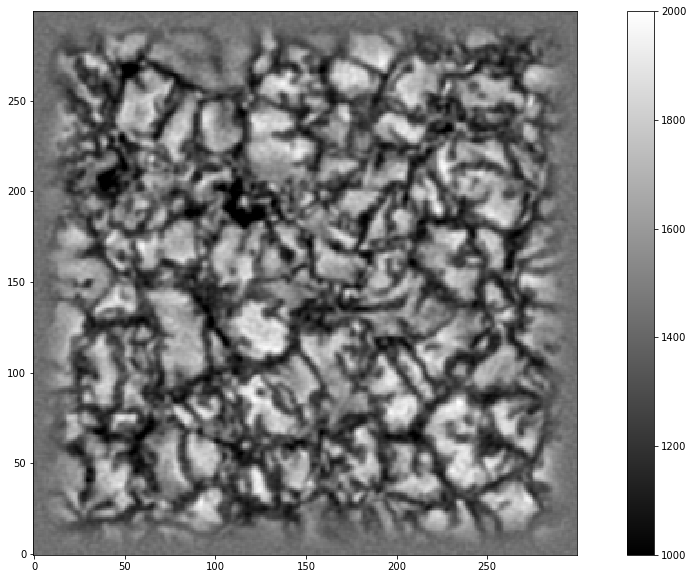

In [262]:

plt.figure(figsize=(18,10))
plt.imshow(ifft2(result[1]).real, origin='lower',cmap='gray',vmin=1000,vmax=2000)
plt.colorbar()

In [263]:
noise(ifft2(result[1]).real[50:250,50:250])

5.309450868021841

In [264]:
RMS_con(ifft2(result[1]).real[50:250,50:250])

0.15037429550063822

In [227]:
noise(masi[50:250,50:250])

5.774360162114274

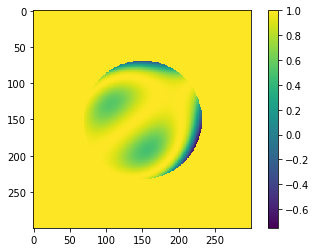

In [197]:

plt.imshow(pupil_func.real)
plt.colorbar()

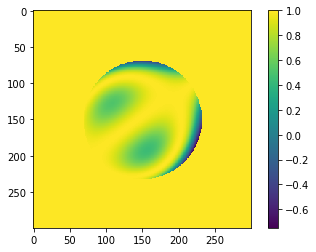

In [198]:
plt.imshow(result[3].real)
plt.colorbar()

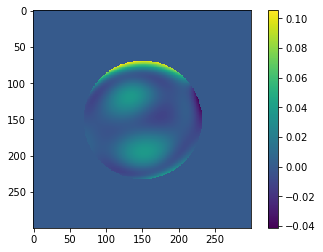

In [199]:
plt.imshow(pupil_func.real -result[3].real )
plt.colorbar()

In [200]:
rms=(RMS_error(pupil_func.real,result[3].real))/(2*np.pi)

In [201]:
1/rms


10.864293677196597

In [81]:
restored = noise_filter*fft2(cont_foc)*np.conj(result[2])/(np.abs(result[2])**2+reg)

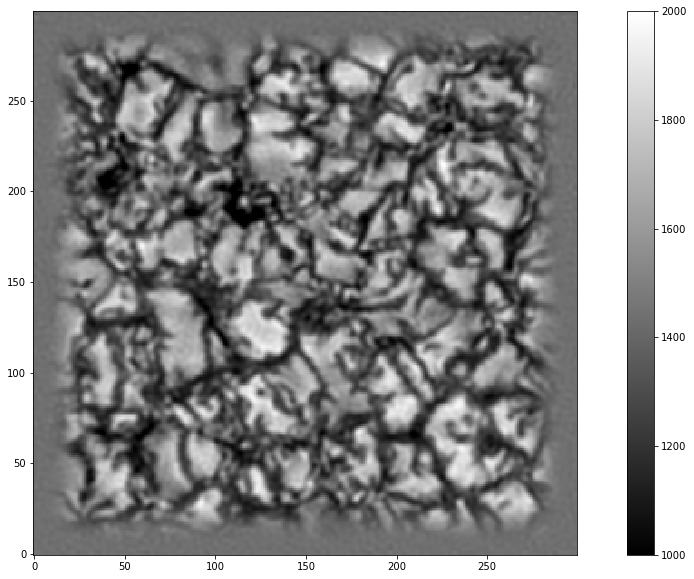

In [82]:
plt.figure(figsize=(18,10))
plt.imshow(ifft2(restored).real, origin='lower',cmap='gray',vmin=1000,vmax=2000)
plt.colorbar()

In [83]:
noise(ifft2(restored).real[50:250,50:250])

3.8600079510565077

In [84]:
RMS_con(ifft2(restored).real[50:250,50:250])

0.14857854889948885

In [85]:
RMS_con(masi[50:250,50:250])

0.14914477714398816

# commission + FS data testing